In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statannot
from bioinfokit import visuz
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [3]:
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

### 1. Bulk RNAseq of dormant vs control cells

In [4]:
X = pd.read_csv("/home/marcc/AXLomics/msresist/data/RNAseq/Kurpa/GSE131594_RNAseq_DormantCells_FPKM.csv")
X = X.drop("gene_id", axis=1)
X = X[~X["gene symbol"].str.contains("ENSG0")]
X = X.replace(0, 0.01)
X.iloc[:, 1:] = np.log2(X.iloc[:, 1:])
X = X.set_index("gene symbol")

In [5]:
df_long = pd.melt(frame=X.reset_index(), id_vars="gene symbol", value_name="log2(FPKM)", value_vars=X.columns[1:])
df_long["Cell Line"] = [s.split("_")[0] for s in df_long["variable"]]
df_long["Dormant"] = [s.split("_")[1].split("_")[0] for s in df_long["variable"]]
df_long = df_long.drop("variable", axis=1)

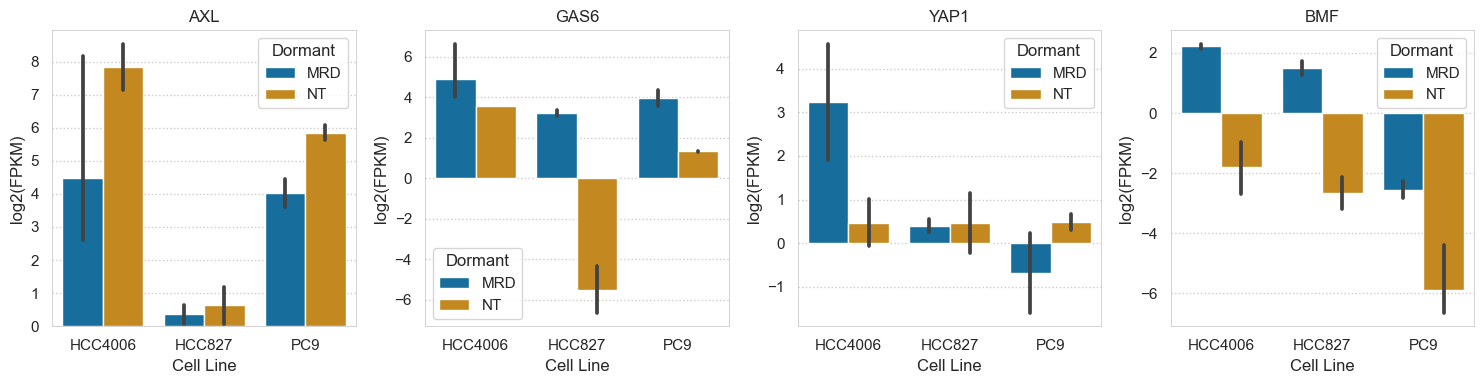

In [7]:
_, ax = plt.subplots(1, 4, figsize=(15, 4))

axl = df_long.set_index("gene symbol").loc["AXL"]
sns.barplot(data=axl, x="Cell Line", y="log2(FPKM)", hue="Dormant", ax=ax[0]).set_title("AXL")

axl = df_long.set_index("gene symbol").loc["GAS6"]
sns.barplot(data=axl, x="Cell Line", y="log2(FPKM)", hue="Dormant", ax=ax[1]).set_title("GAS6")

yap = df_long.set_index("gene symbol").loc["YAP1"]
sns.barplot(data=yap, x="Cell Line", y="log2(FPKM)", hue="Dormant", ax=ax[2]).set_title("YAP1")

bmf = df_long.set_index("gene symbol").loc["BMF"]
sns.barplot(data=bmf, x="Cell Line", y="log2(FPKM)", hue="Dormant", ax=ax[3]).set_title("BMF")

plt.tight_layout()

Text(0.5, 1.0, 'SOS1')

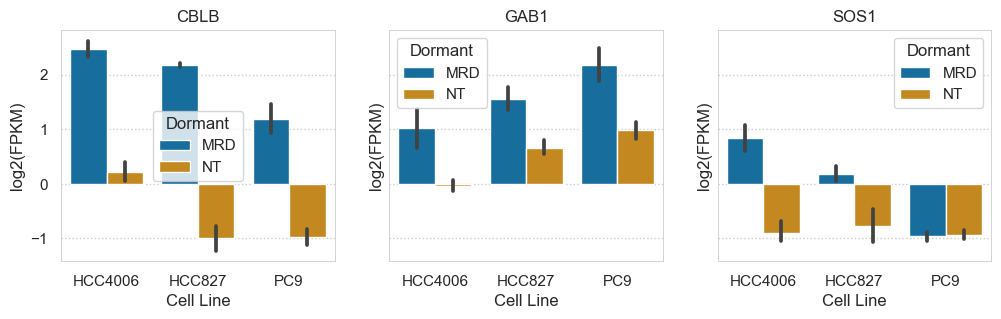

In [6]:
_, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

axl = df_long.set_index("gene symbol").loc["CBLB"]
sns.barplot(data=axl, x="Cell Line", y="log2(FPKM)", hue="Dormant", ax=ax[0], errorbar=('ci', 63)).set_title("CBLB")

yap = df_long.set_index("gene symbol").loc["GAB1"]
sns.barplot(data=yap, x="Cell Line", y="log2(FPKM)", hue="Dormant", ax=ax[1], errorbar=('ci', 63)).set_title("GAB1")

bmf = df_long.set_index("gene symbol").loc["SOS1"]
sns.barplot(data=bmf, x="Cell Line", y="log2(FPKM)", hue="Dormant", ax=ax[2], errorbar=('ci', 63)).set_title("SOS1")

Text(0.5, 1.0, 'FYN')

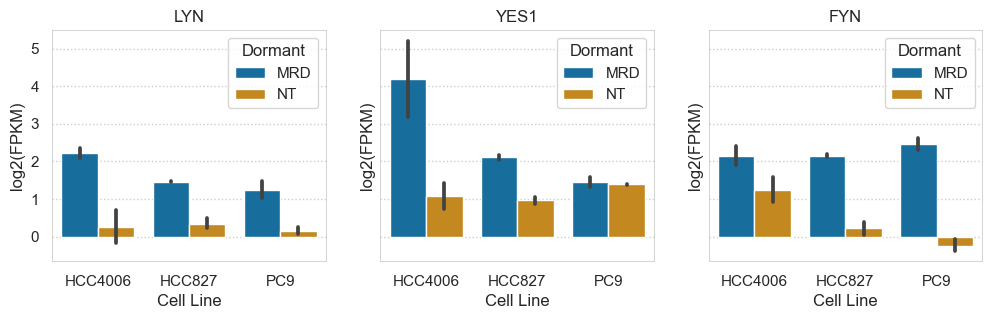

In [7]:
_, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

axl = df_long.set_index("gene symbol").loc["LYN"]
sns.barplot(data=axl, x="Cell Line", y="log2(FPKM)", hue="Dormant", ax=ax[0], errorbar=('ci', 63)).set_title("LYN")

yap = df_long.set_index("gene symbol").loc["YES1"]
sns.barplot(data=yap, x="Cell Line", y="log2(FPKM)", hue="Dormant", ax=ax[1], errorbar=('ci', 63)).set_title("YES1")

bmf = df_long.set_index("gene symbol").loc["FYN"]
sns.barplot(data=bmf, x="Cell Line", y="log2(FPKM)", hue="Dormant", ax=ax[2], errorbar=('ci', 63)).set_title("FYN")

In [8]:
df_long = df_long.set_index("gene symbol")

In [9]:
MS = pd.read_csv("/home/marcc/AXLomics/msresist/data/MS/AXL/ALX_MS_data_wLabels.csv")
cl23 = MS[(MS["Cluster"] == 3) | (MS["Cluster"] == 2)]
cl23_fc = pd.DataFrame()
cl23_fc["Gene"] = cl23["Gene"]
cl23_fc["log2(FC)"] = cl23["PC9 A"] - cl23["KO A"]
rnk = cl23_fc.sort_values(by="log2(FC)", ascending=False).set_index("Gene")

In [10]:
def annotate_pvals(ax, df, x, y, hue=None, box_pairs=[("High", "Low")], verbose=False):
    statannot.add_stat_annotation(
        ax=ax, 
        data=df, 
        x=x, 
        y=y, 
        hue=hue, 
        box_pairs=box_pairs, 
        test="t-test_ind", 
        text_format="star", 
        loc="outside",
        verbose=verbose)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HCC827_MRD v.s. HCC827_NT: t-test independent samples with Bonferroni correction, P_val=6.466e-04 stat=3.720e+00
HCC4006_MRD v.s. HCC4006_NT: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=7.973e-01
PC9_MRD v.s. PC9_NT: t-test independent samples with Bonferroni correction, P_val=6.110e-01 stat=1.272e+00


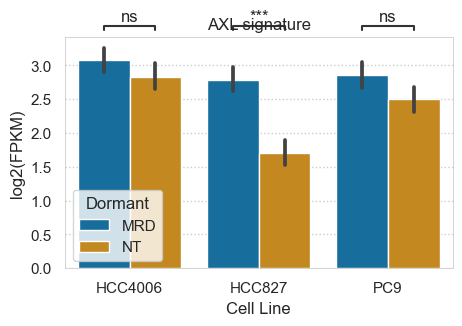

In [54]:
axl_genes = rnk[rnk["log2(FC)"] > np.percentile(rnk, 75)].index.to_list()
for g in axl_genes:
    if g not in df_long.index:
        axl_genes.remove(g)
axl_sign = df_long.loc[axl_genes]

_, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.barplot(data=axl_sign, x="Cell Line", y="log2(FPKM)", hue="Dormant", ax=ax, errorbar=('ci', 63)).set_title("AXL signature")
annotate_pvals(ax, 
            axl_sign, 
            "Cell Line", 
            "log2(FPKM)",
            hue="Dormant",
            box_pairs=[
                (("HCC4006", "MRD"), ("HCC4006", "NT")),
                (("HCC827", "MRD"), ("HCC827", "NT")), 
                (("PC9", "MRD"), ("PC9", "NT"))
                ],
            verbose=True)

### 2. Bulk RNAseq of PC9 YAP KO vs PC9 parental cells

In [29]:
ko = pd.read_csv("/home/marcc/AXLomics/msresist/data/RNAseq/Kurpa/GSE131601_RNAseq_CTRL_YAPKO_FPKM.csv").replace(0, 0.01)
ko.iloc[:, 1:] = np.log(ko.iloc[:, 1:])
ko_long = pd.melt(frame=ko, id_vars="Gene_ID", value_vars=ko.columns[1:], value_name="log2(FPKM)", var_name="Condition")
ko_long.insert(1, "Cell Line", [s.split("_")[0] for s in ko_long["Condition"]])
ko_long.insert(2, "KO", [s.split("_")[1] for s in ko_long["Condition"]])
ko_long.insert(2, "Treatment", [s.split("_")[2] for s in ko_long["Condition"]])
ko_long = ko_long.drop("Condition", axis=1).set_index("Gene_ID")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

OT_CTRL v.s. OT_YAP14: t-test independent samples with Bonferroni correction, P_val=1.003e-03 stat=1.030e+01
NOTX_CTRL v.s. NOTX_YAP14: t-test independent samples with Bonferroni correction, P_val=2.187e-03 stat=-8.411e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

OT_CTRL v.s. OT_YAP30: t-test independent samples with Bonferroni correction, P_val=1.953e-05 stat=2.794e+01
NOTX_CTRL v.s. NOTX_YAP30: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-6.954e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

OT_CTRL v.s. OT_YAP14: t-test independent samples with Bonferr

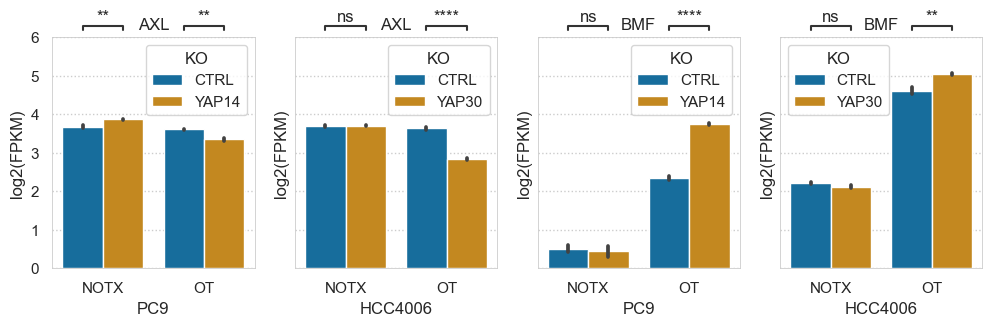

In [48]:
_, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
ax[0].set_ylim(0, 6)
pc9_ko_long = ko_long[ko_long["Cell Line"] == "PC9"].loc["AXL"]
sns.barplot(data=pc9_ko_long, y="log2(FPKM)", x="Treatment", hue="KO", ax=ax[0]).set_title("AXL")
ax[0].set_xlabel("PC9")
annotate_pvals(ax[0], 
            pc9_ko_long, 
            "Treatment", 
            "log2(FPKM)",
            hue="KO",
            box_pairs=[
                (("NOTX", "CTRL"), ("NOTX", "YAP14")),
                (("OT", "CTRL"), ("OT", "YAP14"))
                ],
            verbose=True)

hc4_ko_long = ko_long[ko_long["Cell Line"] == "s4006"].loc["AXL"]
sns.barplot(data=hc4_ko_long, y="log2(FPKM)", x="Treatment", hue="KO", ax=ax[1]).set_title("AXL")
ax[1].set_xlabel("HCC4006")
annotate_pvals(ax[1], 
            hc4_ko_long, 
            "Treatment", 
            "log2(FPKM)",
            hue="KO",
            box_pairs=[
                (("NOTX", "CTRL"), ("NOTX", "YAP30")),
                (("OT", "CTRL"), ("OT", "YAP30"))
                ],
            verbose=True)

pc9_ko_long = ko_long[ko_long["Cell Line"] == "PC9"].loc["BMF"]
sns.barplot(data=pc9_ko_long, y="log2(FPKM)", x="Treatment", hue="KO", ax=ax[2]).set_title("BMF")
ax[2].set_ylim(0, 6)
ax[2].set_xlabel("PC9")
annotate_pvals(ax[2], 
            pc9_ko_long, 
            "Treatment", 
            "log2(FPKM)",
            hue="KO",
            box_pairs=[
                (("NOTX", "CTRL"), ("NOTX", "YAP14")),
                (("OT", "CTRL"), ("OT", "YAP14"))
                ],
            verbose=True)

hc4_ko_long = ko_long[ko_long["Cell Line"] == "s4006"].loc["BMF"]
sns.barplot(data=hc4_ko_long, y="log2(FPKM)", x="Treatment", hue="KO", ax=ax[3]).set_title("BMF")
ax[3].set_xlabel("HCC4006")
annotate_pvals(ax[3], 
            hc4_ko_long, 
            "Treatment", 
            "log2(FPKM)",
            hue="KO",
            box_pairs=[
                (("NOTX", "CTRL"), ("NOTX", "YAP30")),
                (("OT", "CTRL"), ("OT", "YAP30"))
                ],
            verbose=True)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

OT_CTRL v.s. OT_YAP14: t-test independent samples with Bonferroni correction, P_val=6.862e-02 stat=-3.156e+00
NOTX_CTRL v.s. NOTX_YAP14: t-test independent samples with Bonferroni correction, P_val=1.768e-02 stat=-4.770e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

OT_CTRL v.s. OT_YAP30: t-test independent samples with Bonferroni correction, P_val=3.490e-01 stat=-1.649e+00
NOTX_CTRL v.s. NOTX_YAP30: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=3.728e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

OT_CTRL v.s. OT_YAP14: t-test independent samples with Bonfer

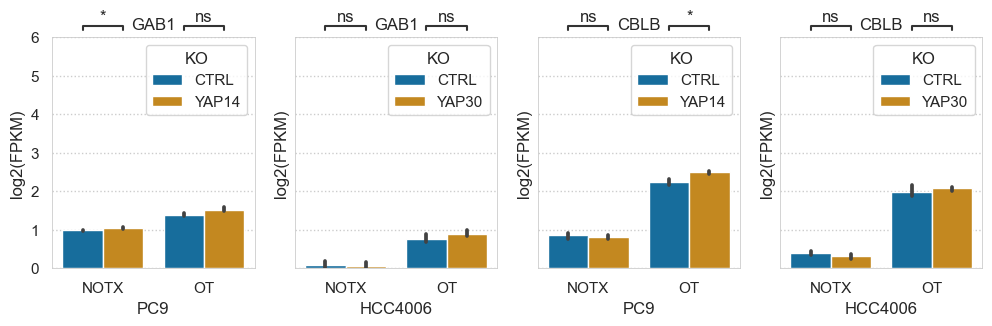

In [70]:
_, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
ax[0].set_ylim(0, 6)
pc9_ko_long = ko_long[ko_long["Cell Line"] == "PC9"].loc["GAB1"]
sns.barplot(data=pc9_ko_long, y="log2(FPKM)", x="Treatment", hue="KO", ax=ax[0]).set_title("GAB1")
ax[0].set_xlabel("PC9")
annotate_pvals(ax[0], 
            pc9_ko_long, 
            "Treatment", 
            "log2(FPKM)",
            hue="KO",
            box_pairs=[
                (("NOTX", "CTRL"), ("NOTX", "YAP14")),
                (("OT", "CTRL"), ("OT", "YAP14"))
                ],
            verbose=True)

hc4_ko_long = ko_long[ko_long["Cell Line"] == "s4006"].loc["GAB1"]
sns.barplot(data=hc4_ko_long, y="log2(FPKM)", x="Treatment", hue="KO", ax=ax[1]).set_title("GAB1")
ax[1].set_xlabel("HCC4006")
annotate_pvals(ax[1], 
            hc4_ko_long, 
            "Treatment", 
            "log2(FPKM)",
            hue="KO",
            box_pairs=[
                (("NOTX", "CTRL"), ("NOTX", "YAP30")),
                (("OT", "CTRL"), ("OT", "YAP30"))
                ],
            verbose=True)

pc9_ko_long = ko_long[ko_long["Cell Line"] == "PC9"].loc["CBLB"]
sns.barplot(data=pc9_ko_long, y="log2(FPKM)", x="Treatment", hue="KO", ax=ax[2]).set_title("CBLB")
ax[2].set_xlabel("PC9")
annotate_pvals(ax[2], 
            pc9_ko_long, 
            "Treatment", 
            "log2(FPKM)",
            hue="KO",
            box_pairs=[
                (("NOTX", "CTRL"), ("NOTX", "YAP14")),
                (("OT", "CTRL"), ("OT", "YAP14"))
                ],
            verbose=True)

hc4_ko_long = ko_long[ko_long["Cell Line"] == "s4006"].loc["CBLB"]
sns.barplot(data=hc4_ko_long, y="log2(FPKM)", x="Treatment", hue="KO", ax=ax[3]).set_title("CBLB")
ax[3].set_xlabel("HCC4006")
annotate_pvals(ax[3], 
            hc4_ko_long, 
            "Treatment", 
            "log2(FPKM)",
            hue="KO",
            box_pairs=[
                (("NOTX", "CTRL"), ("NOTX", "YAP30")),
                (("OT", "CTRL"), ("OT", "YAP30"))
                ],
            verbose=True)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

OT_CTRL v.s. OT_YAP14: t-test independent samples with Bonferroni correction, P_val=1.845e-04 stat=-1.586e+01
NOTX_CTRL v.s. NOTX_YAP14: t-test independent samples with Bonferroni correction, P_val=3.246e-02 stat=-3.993e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

OT_CTRL v.s. OT_YAP30: t-test independent samples with Bonferroni correction, P_val=2.268e-04 stat=-1.506e+01
NOTX_CTRL v.s. NOTX_YAP30: t-test independent samples with Bonferroni correction, P_val=9.883e-03 stat=-5.616e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

OT_CTRL v.s. OT_YAP14: t-test independent samples with Bonfe

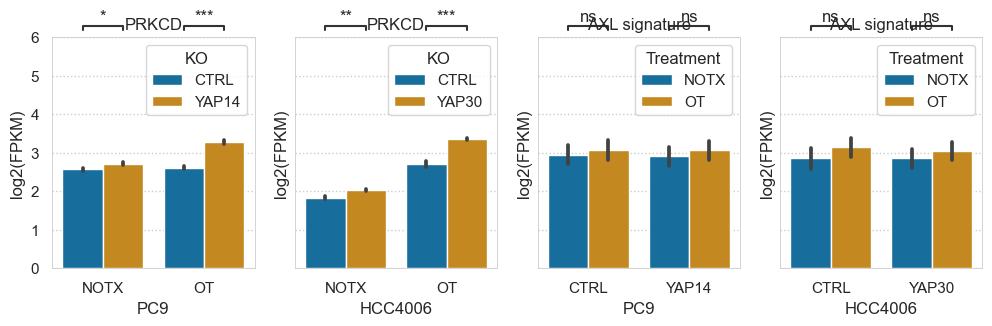

In [76]:
_, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
ax[0].set_ylim(0, 6)
pc9_ko_long = ko_long[ko_long["Cell Line"] == "PC9"].loc["PRKCD"]
sns.barplot(data=pc9_ko_long, y="log2(FPKM)", x="Treatment", hue="KO", ax=ax[0]).set_title("PRKCD")
ax[0].set_xlabel("PC9")
annotate_pvals(ax[0], 
            pc9_ko_long, 
            "Treatment", 
            "log2(FPKM)",
            hue="KO",
            box_pairs=[
                (("NOTX", "CTRL"), ("NOTX", "YAP14")),
                (("OT", "CTRL"), ("OT", "YAP14"))
                ],
            verbose=True)

hc4_ko_long = ko_long[ko_long["Cell Line"] == "s4006"].loc["PRKCD"]
sns.barplot(data=hc4_ko_long, y="log2(FPKM)", x="Treatment", hue="KO", ax=ax[1]).set_title("PRKCD")
ax[1].set_xlabel("HCC4006")
annotate_pvals(ax[1], 
            hc4_ko_long, 
            "Treatment", 
            "log2(FPKM)",
            hue="KO",
            box_pairs=[
                (("NOTX", "CTRL"), ("NOTX", "YAP30")),
                (("OT", "CTRL"), ("OT", "YAP30"))
                ],
            verbose=True)

pc9_ko_long = ko_long[ko_long["Cell Line"] == "PC9"].loc[axl_genes]
sns.barplot(data=pc9_ko_long, y="log2(FPKM)", x="KO", hue="Treatment", ax=ax[2]).set_title("AXL signature")
ax[2].set_xlabel("PC9")
annotate_pvals(ax[2], 
            pc9_ko_long, 
            "Treatment", 
            "log2(FPKM)",
            hue="KO",
            box_pairs=[
                (("NOTX", "CTRL"), ("NOTX", "YAP14")),
                (("OT", "CTRL"), ("OT", "YAP14"))
                ],
            verbose=True)

hc4_ko_long = ko_long[ko_long["Cell Line"] == "s4006"].loc[axl_genes]
sns.barplot(data=hc4_ko_long, y="log2(FPKM)", x="KO", hue="Treatment", ax=ax[3]).set_title("AXL signature")
ax[3].set_xlabel("HCC4006")
annotate_pvals(ax[3], 
            hc4_ko_long, 
            "Treatment", 
            "log2(FPKM)",
            hue="KO",
            box_pairs=[
                (("NOTX", "CTRL"), ("NOTX", "YAP30")),
                (("OT", "CTRL"), ("OT", "YAP30"))
                ],
            verbose=True)